## Code Made by : Andres Felipe Villalba Cortes

In [1]:
import nltk
import numpy as np
import json
import glob

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from nltk.corpus import stopwords

import pyLDAvis
import pyLDAvis.gensim
import nltk
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xlrd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from itertools import combinations
import community
from collections import Counter
from nltk.stem import WordNetLemmatizer 
from scipy.stats import pearsonr
from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from wordcloud import WordCloud
from mpl_toolkits.mplot3d import Axes3D

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def load_data(file):
    with open (file, "r", encoding= "utf-8") as f:
        data = json.load(f)
    return (data)

def write_data(file, data):
    with open ( file, "w" , encodin = "utf-8") as f:
        json.dump(data, f, indent = 4)

In [3]:
excel_file = pd.ExcelFile("Proyecto. Dep-Física.xlsx")
lemmatizer = WordNetLemmatizer()
DATA = []
Names = []
Enlace = []
Total = 0
for sheet_name in excel_file.sheet_names:
    df = pd.read_excel("Proyecto. Dep-Física.xlsx", sheet_name= sheet_name)
    df = df.dropna(subset=["Descripción original"])
    num_filas , num_columns = df.shape
    Total = num_filas+Total
    for row in range(num_filas):
        data= df.iloc[row,3]
        Enlace.append(df.iloc[row,11])
        Names.append(df.iloc[row,0])                
        if type(data) != str:
            data= "" 
        DATA.append(data)
    

data = DATA
print("# de papers:", Total)



# de papers: 616


# Lemmatización
La lematización es un proceso de procesamiento del lenguaje natural que consiste en reducir las palabras a su forma base o raíz, conocida como "lema". El objetivo de la lematización es reducir las diferentes formas de una palabra a una sola forma común para facilitar su análisis y comprensión. Por ejemplo, las palabras "corriendo", "corre" y "corrió" se reducen al lema "correr". La lematización es útil en tareas como la recuperación de información, la clasificación de textos y el análisis de sentimientos.

In [4]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


lemmatized_texts = lemmatization(data)

In [5]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)   # si hay palabras de otro idioma
        final.append(new)
    return (final) 

data_words = gen_words(lemmatized_texts)


# Bigramas:
Pares de palabras estrechamente relacionadas. Ejemplo: Euler-Lagrange
# Trigramas:
Trios de palabras estrechamente relacionadas. Ejemplo: Leyes-de-Newton 

In [6]:
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100) ######Threshold Caution Phrases

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)


# TF - IDF
TF-IDF significa "Term Frequency-Inverse Document Frequency" y es una técnica utilizada en procesamiento de lenguaje natural para evaluar la importancia de una palabra en un documento. La técnica se basa en dos factores: la frecuencia con que aparece una palabra en un documento (TF) y la frecuencia inversa de documentos que contienen esa palabra (IDF). En resumen, TF-IDF mide cuán relevante es una palabra para un documento específico al comparar su frecuencia dentro del documento con su frecuencia en el corpus completo. Esta técnica se utiliza comúnmente en tareas como recuperación de información, clasificación de texto y análisis de sentimiento.

In [7]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]  # indice, frecuencia

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.06 # 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf score 0 will be missing   -----> Filtro de Palab ras

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

## Visualizing Data

In [53]:
Number_of_Topics = 11

lda_model1 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=Number_of_Topics,                           ##### Numero de Temas
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [54]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model1, corpus, id2word, mds="mmds", R=30)
vis  

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.255806 -0.285863       1        1  31.986117
6      0.375131 -0.053163       2        1  19.982953
7      0.348097  0.218386       3        1   9.545799
5      0.096545  0.367571       4        1   9.217316
8     -0.006698 -0.393245       5        1   6.818040
0     -0.358540 -0.036255       6        1   5.049628
10    -0.259880 -0.247112       7        1   5.048673
9     -0.184907  0.174167       8        1   4.278785
4     -0.253290  0.291459       9        1   3.927179
3      0.035954  0.080412      10        1   2.514284
2     -0.048218 -0.116356      11        1   1.631227, topic_info=             Term        Freq       Total Category  logprob  loglift
103       process  182.000000  182.000000  Default  30.0000  30.0000
670     operation  155.000000  155.000000  Default  29.0000  29.0000
1039      student  402.000000  402.000000  Default  28.0000  28.0000
38    temperature  254.000000  254.000000  Default  27.0000  27.0000
37         system  142.000000  142.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
443        supply    6.927952    9.362110  Topic11  -4.5678   3.8147
756      equation   11.431081   27.916210  Topic11  -4.0671   3.2230
965          acid    8.310468   24.148748  Topic11  -4.3859   3.0491
1034  performance    9.960318   52.150411  Topic11  -4.2048   2.4603
743    respective    5.310460   19.260531  Topic11  -4.8337   2.8275

[494 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5203     10  0.913011    accident
1067     10  0.930981  accomplish
851       7  0.975267     acetate
5009     11  0.895025      acetic
965       5  0.621150        acid
...     ...       ...         ...
1326      1  0.990530        year
4576     10  0.855359      yellow
649       8  0.162480         zno
649      10  0.812401         zno
5003      8  0.925638         zro

[609 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 8, 6, 9, 1, 11, 10, 5, 4, 3])

## Qué es cada tema ?


In [55]:
# ¿ De qué esta formado cada tema ? 
all_topic_words = lda_model1.print_topics(num_topics = lda_model1.num_topics)
all_topic_words

[(0,
  '0.035*"define" + 0.027*"efficiency" + 0.026*"degradation" + 0.021*"condition" + 0.018*"methodology" + 0.018*"follow" + 0.015*"complete" + 0.015*"feed" + 0.014*"mass" + 0.014*"gap"'),
 (1,
  '0.031*"student" + 0.017*"concept" + 0.013*"test" + 0.012*"learning" + 0.011*"strategy" + 0.010*"teaching" + 0.009*"learn" + 0.009*"group" + 0.009*"work" + 0.008*"design"'),
 (2,
  '0.049*"grid" + 0.032*"fit" + 0.017*"mapping" + 0.017*"equation" + 0.015*"implicit" + 0.015*"nlinfit" + 0.015*"integration" + 0.015*"performance" + 0.013*"training" + 0.013*"deviation"'),
 (3,
  '0.023*"synthesis" + 0.023*"coefficient" + 0.018*"dye" + 0.016*"nitrobenzene" + 0.015*"also" + 0.015*"zno" + 0.014*"initial" + 0.013*"accomplish" + 0.013*"amount" + 0.012*"nitrate"'),
 (4,
  '0.096*"operation" + 0.025*"different" + 0.023*"scheme" + 0.021*"operate" + 0.017*"mathematical" + 0.015*"criterion" + 0.015*"site" + 0.013*"day" + 0.012*"model" + 0.011*"agreement"'),
 (5,
  '0.038*"system" + 0.025*"value" + 0.023*"pa

## Temas en un Documento

El siguiente código identifica qué temas componen al documento con su proporción respectiva

In [56]:

j = 0
for i, doc in enumerate(corpus):
    doc_topics = lda_model1.get_document_topics(doc)
    sorted_topics = sorted(doc_topics, key = lambda x: x[1], reverse = True)
    
    Documento = Names[j]
    j = j+1
    print(f"{Documento}{i+1}:")
    for topic_id, prob in sorted_topics:
        print(f"Tema {topic_id}: Probabilidad {prob}")
    print("********************************************")

XPS structure analysis of TiN/TiC bilayers produced by pulsed vacuum arc discharge Análisis estructural de bicapas de TiN/TiC producidas por descargas pulsadas por arco en vacío1:
Tema 6: Probabilidad 0.884017825126648
Tema 7: Probabilidad 0.05042877420783043
Tema 5: Probabilidad 0.02803240343928337
********************************************
XPS structure analysis of TiN/TiC bilayers produced by pulsed vacuum arc discharge2:
Tema 6: Probabilidad 0.9002456068992615
Tema 5: Probabilidad 0.05233286693692207
Tema 1: Probabilidad 0.010447072796523571
********************************************
Comparative study between natural and synthetic hydroxyapatite: Structural, morphological and bioactivity properties3:
Tema 8: Probabilidad 0.7391471266746521
Tema 6: Probabilidad 0.12993206083774567
Tema 1: Probabilidad 0.05843660607933998
Tema 7: Probabilidad 0.05080832540988922
********************************************
Effect of the roasting process on glass transition and phase transition of

El siguiente código presenta los documentos que tienen una fuerte proporció de un tema en específico ( siendo así representativo del tema ) para identificar qué es cada tema. Además, da como output el doi para poder leer el paper e identificar las palabras clave 

In [57]:
# Temas Filtrados para los que tienen una probabilidad mayor a 0.8 en un tema en específico

j = 0
for i, doc in enumerate(corpus):
    doc_topics = lda_model1.get_document_topics(doc)
    sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    
    Documento = Names[j]
    link = Enlace[j]
    j = j + 1
    
    for topic_id, prob in sorted_topics:
        if prob > 0.9:
            print(f"{Documento}{i+1}")
            print(f"{link}")
            print(f"Tema {topic_id}: Probabilidad {prob}")
            print("*********************************")

XPS structure analysis of TiN/TiC bilayers produced by pulsed vacuum arc discharge2
https://www.researchgate.net/publication/49598678_XPS_structure_analysis_of_TiNTiC_bilayers_produced_by_pulsed_vacuum_arc_discharge
Tema 6: Probabilidad 0.9002457857131958
*********************************
Producción y caracterización de películas de TiN/TiC por PAPVD por arco pulsado variando la temperatura del sustrato.19
https://repositorio.unal.edu.co/handle/unal/70177
Tema 6: Probabilidad 0.9330936670303345
*********************************
Producción y simulación de nanotubos de carbono crecidos por la técnica deposición química de vapores optimizada por plasma.21
https://repositorio.unal.edu.co/handle/unal/7208
Tema 6: Probabilidad 0.9557326436042786
*********************************
THERMAL STABILITY OF WC COATINGS PRODUCED BY DC MAGNETRON SPUTTERING32
https://www.researchgate.net/publication/277076375_THERMAL_STABILITY_OF_WC_COATINGS_PRODUCED_BY_DC_MAGNETRON_SPUTTERING
Tema 6: Probabilidad 0.91

Posterior a ponerle label a cada Topic podemos realizar la identificación del teta.

Tarea:
Elegir 10 documentos con puntaje sfuertes para la determinacion del label

## Similaridad de Documentos por el coseno en el N-espacio en proceso... !

Documentos con similares distribuciones de temas (Tetas) deben ser similares entre sí
Cada documento está representado por un N espacio de acuerdo a la cantidad N de temas escogidos y su vector tiene componentes en cada una de ellas de acuerdo a la probabilidad que tiene ese documento en pertenecer a cada tema

In [58]:
# Crear una lista para almacenar los temas y sus probabilidades para cada documento
document_topic_list = []

# Obtener los temas dominantes para cada documento
for i, doc in enumerate(corpus):
    doc_topics = lda_model1.get_document_topics(doc)
    document_topics = [(topic_id, prob) for topic_id, prob in doc_topics]
    
    # Verificar si el documento no tiene puntaje para algún tema y agregar una tupla con puntaje 0
    for topic_id in range(Number_of_Topics):
        if topic_id not in [topic[0] for topic in document_topics]:
            document_topics.append((topic_id, 0))
    
    # Ordenar las tuplas en la sublista en el mismo orden de temas
    document_topics = sorted(document_topics, key=lambda x: x[0])
    
    document_topic_list.append(document_topics)



Representa una tupla (x,y). x:  Topic, y: proporción del tema dentro del documento


In [59]:
document_topic_list

[[(0, 0),
  (1, 0),
  (2, 0),
  (3, 0),
  (4, 0),
  (5, 0.028032936),
  (6, 0.884017),
  (7, 0.050428614),
  (8, 0),
  (9, 0),
  (10, 0)],
 [(0, 0),
  (1, 0.01047167),
  (2, 0),
  (3, 0),
  (4, 0),
  (5, 0.05233391),
  (6, 0.9002186),
  (7, 0),
  (8, 0),
  (9, 0),
  (10, 0)],
 [(0, 0),
  (1, 0.058420382),
  (2, 0),
  (3, 0),
  (4, 0),
  (5, 0),
  (6, 0.12993018),
  (7, 0.050825816),
  (8, 0.739148),
  (9, 0),
  (10, 0)],
 [(0, 0.094526425),
  (1, 0),
  (2, 0),
  (3, 0.01804049),
  (4, 0),
  (5, 0.82295847),
  (6, 0.0114952745),
  (7, 0),
  (8, 0),
  (9, 0),
  (10, 0.023154529)],
 [(0, 0),
  (1, 0),
  (2, 0),
  (3, 0),
  (4, 0.15150043),
  (5, 0.28927785),
  (6, 0.46022582),
  (7, 0.056400165),
  (8, 0),
  (9, 0),
  (10, 0.019125327)],
 [(0, 0),
  (1, 0.021436924),
  (2, 0),
  (3, 0),
  (4, 0.33376932),
  (5, 0.06515842),
  (6, 0.53910506),
  (7, 0),
  (8, 0.02372821),
  (9, 0),
  (10, 0)],
 [(0, 0),
  (1, 0.012112133),
  (2, 0.057655193),
  (3, 0.0175794),
  (4, 0.023276782),
  (5, 0.0

In [60]:
import plotly.graph_objects as go

# Definir los colores correspondientes a cada tema
colors = ['green', 'blue', 'red']

# Extraer las coordenadas en cada eje
x_coords = []
y_coords = []
z_coords = []
dominant_topics = []


for sublist in document_topic_list:
    x_coords.append(sublist[0][1])
    y_coords.append(sublist[1][1])
    z_coords.append(sublist[2][1])
    a = max(sublist[0][1],sublist[1][1],sublist[2][1])
    for i in range(0,3):
        if sublist[i][1] == a:
            dominant_topics.append(i)
            
    

# Obtener el tema dominante para cada punto



#dominant_topics = [max(sublist[1]) for sublist in document_topic_list]

# Crear una figura 3D interactiva
fig = go.Figure(data=[go.Scatter3d(
    x=x_coords,
    y=y_coords,
    z=z_coords,
    mode='markers',
    marker=dict(
        size=5,
        color=[colors[topic] for topic in dominant_topics],
        opacity=0.8
    )
)])

# Configurar las etiquetas de los ejes
fig.update_layout(scene=dict(
    xaxis_title='Tema 1',
    yaxis_title='Tema 2',
    zaxis_title='Tema 3'
))

# Mostrar la figura interactiva
fig.show()


# Azul = tema 1
# Red = tema 2
# Green = tema 3


In [73]:
#Proporción de Documentos


# Azul = tema 1
# Red = tema 2
# Green = tema 3

colors = ['Tema 11', 'Tema 1', 'Tema 2',"3","4","5","6","7","8","9","10"]

# Contar los puntos de cada color
counts = [len([t for t in dominant_topics if t == topic]) for topic in range(11)]


# Mostrar el conteo de puntos por color
for topic, count in enumerate(counts):
    color_name = colors[topic]
    print('Porcentaje de documentos en el {}: {} %'.format(color_name, round(count*100/len(dominant_topics),2)))


Porcentaje de documentos en el Tema 11: 20.63 %
Porcentaje de documentos en el Tema 1: 68.91 %
Porcentaje de documentos en el Tema 2: 10.46 %
Porcentaje de documentos en el 3: 0.0 %
Porcentaje de documentos en el 4: 0.0 %
Porcentaje de documentos en el 5: 0.0 %
Porcentaje de documentos en el 6: 0.0 %
Porcentaje de documentos en el 7: 0.0 %
Porcentaje de documentos en el 8: 0.0 %
Porcentaje de documentos en el 9: 0.0 %
Porcentaje de documentos en el 10: 0.0 %


Preguntar a Viviescas como evaluar la participacion de un autor.

Papers publicados pertenecientes a cada tema/ Papers totales del tema

Con citaciones?

In [62]:
coherence_model_lda = CoherenceModel(model=lda_model1, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)


nCoherence Score:  0.4511024366457681


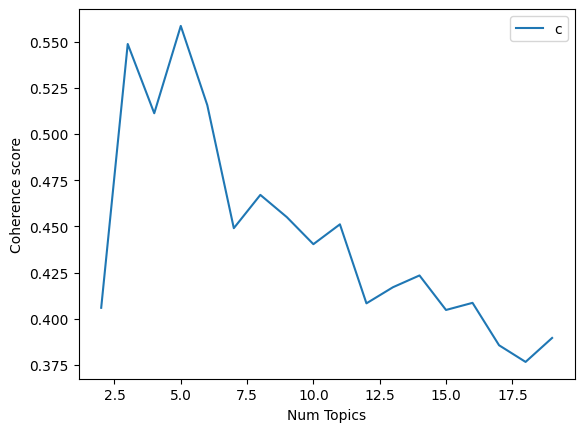

In [63]:
def compute_coherence_values(corpus1=corpus, id2word=id2word, texts1 = texts):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    corpus = texts
    coherence_values = []
    for num_topics in range(2, 20):
        
        
        lda_model1 = gensim.models.ldamodel.LdaModel(corpus=corpus1,
                                           id2word=id2word,
                                           num_topics=num_topics,                          
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")    
    
    
        coherence_model_lda = CoherenceModel(model=lda_model1, texts=texts1, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_values.append(coherence_lda)
        
        


    return  coherence_values

coherence_values = compute_coherence_values()


# Show graph

x = range(2, 20, 1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Mejor número de Temas por máxima verosimilitud

In [64]:
# Búsqueda de Máxima verosimilutid ---> Número Óptimo de Topics
# Al parecer siempre busca el mínimo   -  X no recomendado

num_topics_range = range(5,20)


def calculate_log_likelihood(num_topics, corpus=corpus, id2word= id2word):
    disctionary = id2word
    corpus = corpus
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word = id2word, num_topics= num_topics , alpha= "auto", eta="auto")
    log_likelihood = lda_model.log_perplexity(corpus)
    return log_likelihood
    
def find_optimal_parameters(num_topics_range=num_topics_range , corpus=corpus):
    
    best_log_likelihood = float("-inf")
    best_num_topics = None
    
    for num_topics in num_topics_range:
        log_likelihood = calculate_log_likelihood(num_topics)
        if log_likelihood > best_log_likelihood:
            best_log_likelihood =  log_likelihood
            best_num_topics = num_topics
            
    return best_num_topics

best_num_topics = find_optimal_parameters()
    
print("Mejor número de Temas:", best_num_topics)

Mejor número de Temas: 5


## Temas en cada Paper


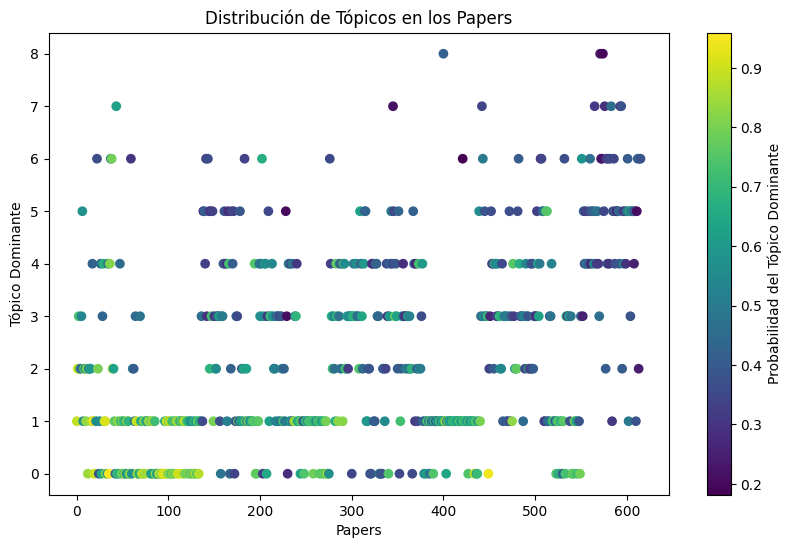

In [65]:
topic_distribution = [lda_model1.get_document_topics(doc) for doc in corpus]
# Obtener los valores de probabilidad de los tópicos
max_topics = max([len(doc_topics) for doc_topics in topic_distribution])
topic_probabilities = np.zeros((len(topic_distribution), max_topics))

for i, doc_topics in enumerate(topic_distribution):
    for j, (_, prob) in enumerate(doc_topics):
        topic_probabilities[i, j] = prob

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(range(len(topic_probabilities)), topic_probabilities.argmax(axis=1), c=topic_probabilities.max(axis=1), cmap='viridis')
plt.colorbar(label='Probabilidad del Tópico Dominante')
plt.xlabel('Papers')
plt.ylabel('Tópico Dominante')
plt.title('Distribución de Tópicos en los Papers')
plt.show()

# Posibilidad de diferenciar por cada investigador
 Lo mismo con la matriz

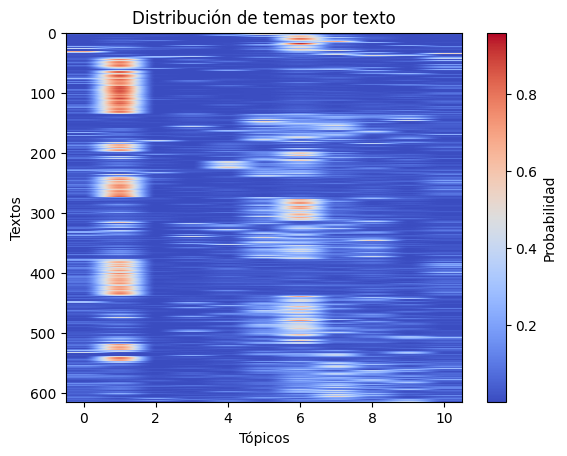

In [66]:
# Crear una matriz para almacenar la distribución de temas de cada texto
topic_distribution_matrix = np.zeros((len(corpus), Number_of_Topics))

# Obtener la distribución de temas para cada texto
for i, doc in enumerate(corpus):
    doc_topics = lda_model1.get_document_topics(doc, minimum_probability=0.0)
    for topic_id, prob in doc_topics:
        topic_distribution_matrix[i, topic_id] = prob
# Visualizar la matriz con colores
plt.imshow(topic_distribution_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Probabilidad')
plt.xlabel('Tópicos')
plt.ylabel('Textos')
plt.title('Distribución de temas por texto')
plt.show()

## WordCloud

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



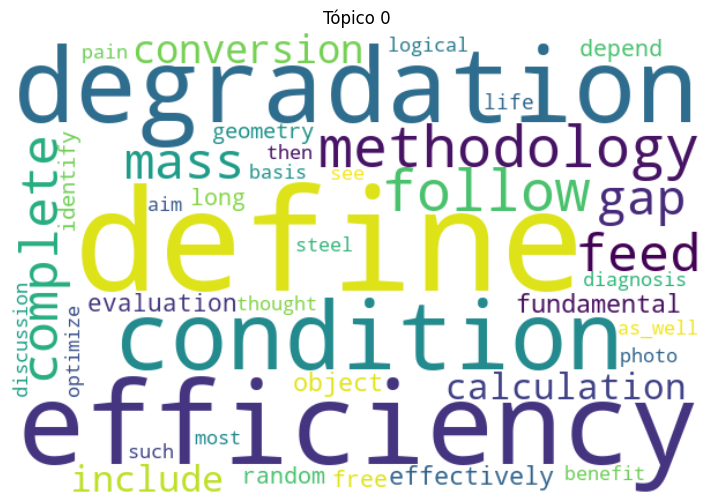

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



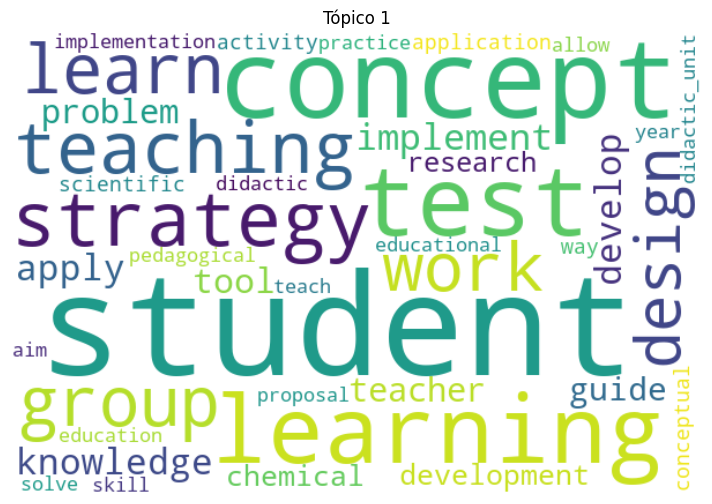

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



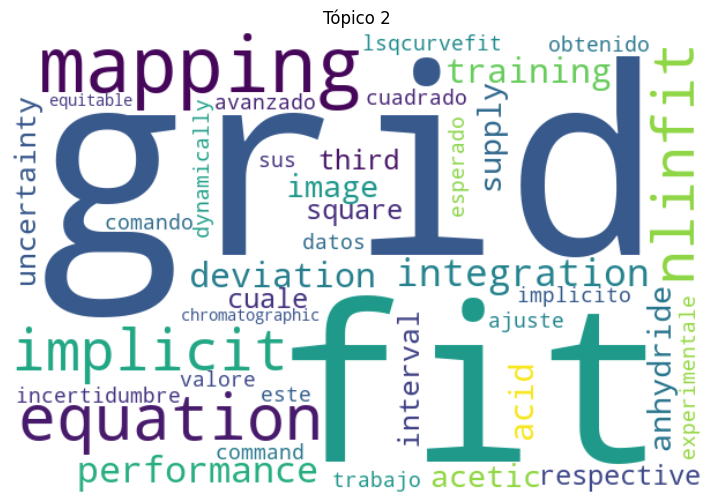

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



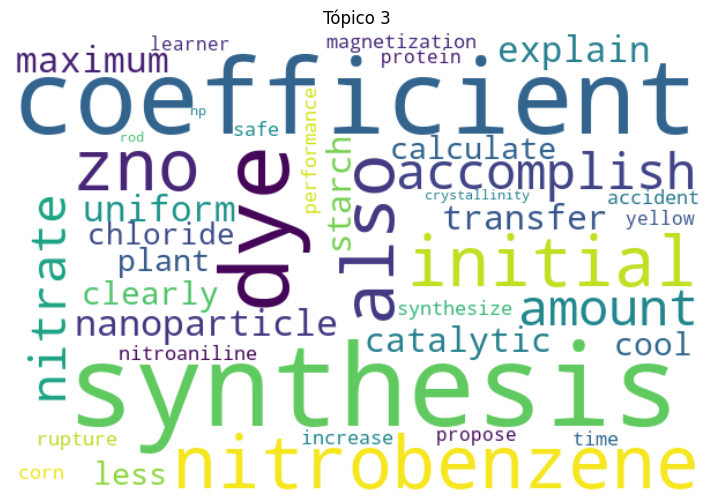

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



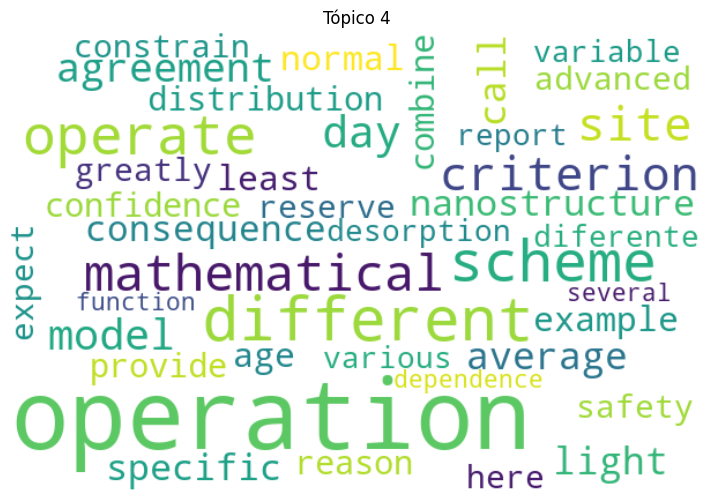

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



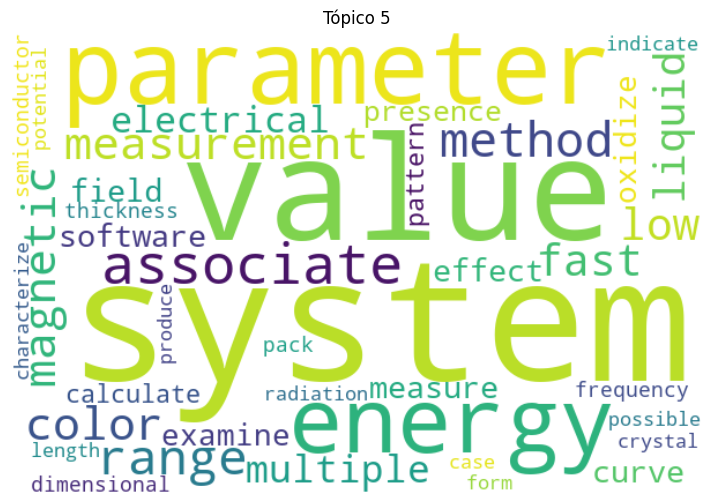

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



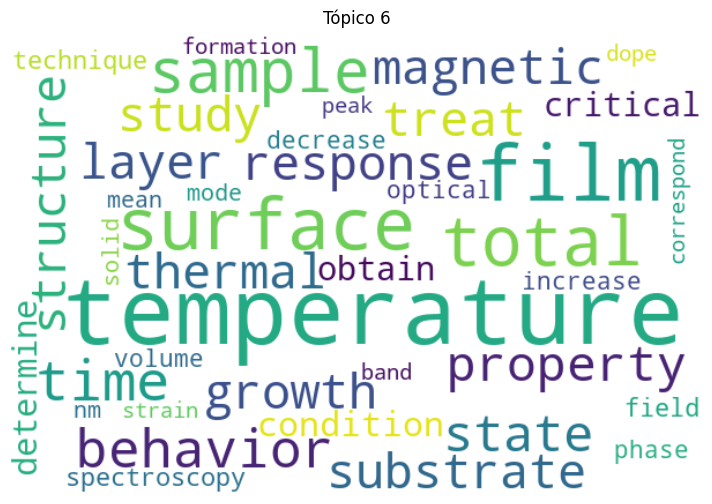

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



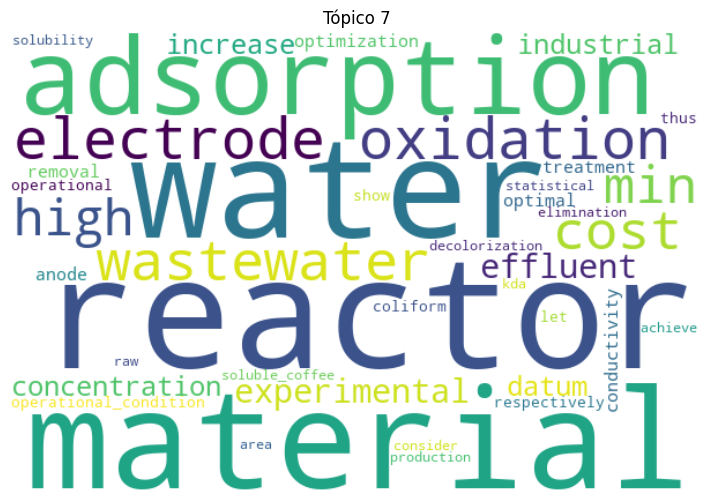

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



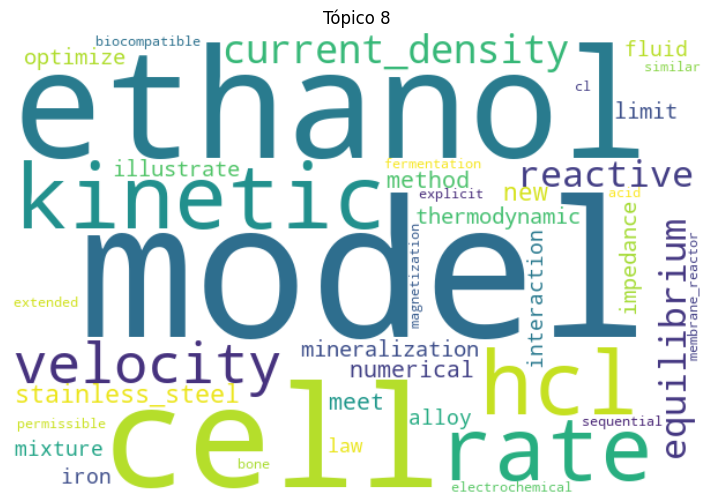

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



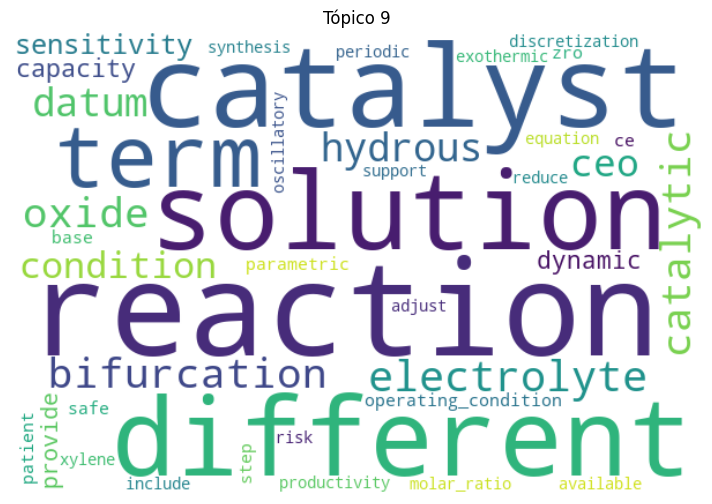

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



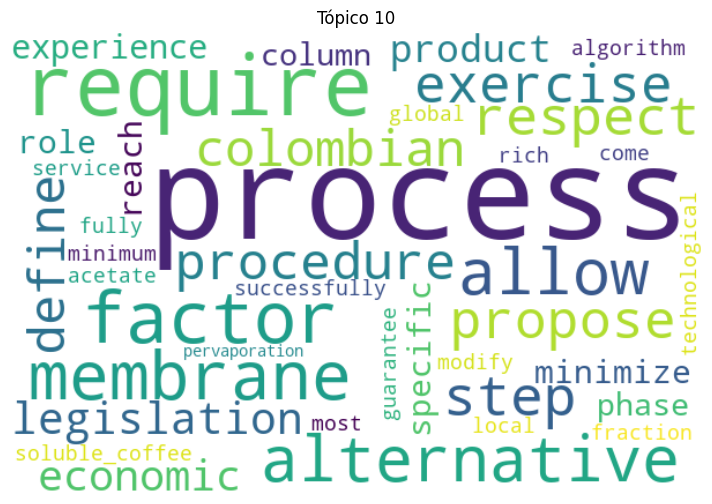

In [67]:
# Obtener las palabras clave de cada tópico
topics_keywords = lda_model1.show_topics(num_topics=Number_of_Topics, num_words=40, formatted=False)

# Crear una nube de palabras para cada tópico
for topic_id, keywords in topics_keywords:
    wordcloud = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(dict(keywords))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Tópico {topic_id}')
    plt.show()

## Save and load Model

In [68]:
Number_of_Topics = 2

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=Number_of_Topics,                           ##### Numero de Temas
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [69]:
lda_model.save("LDA_Model")

In [70]:
new_model =  gensim.models.ldamodel.LdaModel.load("LDA_Model")


In [71]:
test_doc = corpus[-1]

vector = new_model[test_doc]

def Sort(sub_li):
    sub_li.sort(key=lambda x: x[1])
    sub_li.reverse()
    return (sub_li)

new_vector =Sort(vector)
print(new_vector)

[(0, 0.809127), (1, 0.190873)]


In [72]:
# Ejemplo para cuando pedimos solo 2 temas
test_doc = corpus[-1]

vector = lda_model[test_doc]


def Sort(sub_li):
    sub_li.sort(key=lambda x: x[1])
    sub_li.reverse()
    return (sub_li)

new_vector =Sort(vector)
print(new_vector)

[(0, 0.809127), (1, 0.190873)]


## !
- Aumentar IFT = 0.08 > 0.03
- Hacer código para determinar el # Topics óptimo por coherencia 
- Hacer código para determinar el # Topics óptimo por maxima verosimilitud
- Temas en cada paper por graph y matriz 
- WordCloud
